In [ ]:
#|hide
#|eval: false
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [ ]:
#|hide
#|eval: false
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [ ]:
#|export
# Python native modules
from typing import *
from typing_extensions import Literal
import typing 
from warnings import warn
# Third party libs
import numpy as np
import torch
from torch import nn
from torch.distributions import *
import torchdata.datapipes as dp 
from torchdata.dataloader2.graph import DataPipe,traverse,replace_dp
from fastcore.all import test_eq,test_ne,ifnone,L
from torch.optim import AdamW,Adam
# Local modules
from fastrl.core import *
from fastrl.pipes.core import *
from fastrl.torch_core import *
from fastrl.layers import *
from fastrl.data.block import *
from fastrl.envs.gym import *
from fastrl.agents.trpo import *
from fastrl.loggers.vscode_visualizers import VSCodeTransformBlock
from fastrl.loggers.jupyter_visualizers import ProgressBarLogger
from fastrl.agents.discrete import EpsilonCollector
from fastrl.agents.core import AgentHead,StepFieldSelector,AgentBase 
from fastrl.agents.ddpg import ActionClip,ActionUnbatcher,NumpyConverter,OrnsteinUhlenbeck,SimpleModelRunner
from fastrl.loggers.core import LoggerBase,CacheLoggerBase
from fastrl.dataloader2_ext import InputInjester
from fastrl.loggers.core import LoggerBasePassThrough,BatchCollector,EpocherCollector,RollingTerminatedRewardCollector,EpisodeCollector
from fastrl.learner.core import LearnerBase,LearnerHead
from fastrl.pipes.core import *
from fastrl.pipes.iter.nskip import *
from fastrl.pipes.iter.nstep import *
from fastrl.pipes.iter.firstlast import *
from fastrl.pipes.iter.transforms import *
from fastrl.pipes.map.transforms import *
from fastrl.data.block import *
from fastrl.torch_core import *
from fastrl.layers import *
from fastrl.data.block import *
from fastrl.envs.gym import *
from fastrl.agents.ddpg import LossCollector,BasicOptStepper,StepBatcher
from fastrl.loggers.core import LogCollector
from fastrl.agents.discrete import EpsilonCollector


# PPO
> [Proximate Policy Gradients](https://arxiv.org/pdf/1707.06347.pdf)

In [ ]:
#|export
class PPOActorOptAndLossProcessor(dp.iter.IterDataPipe):
    debug:bool=False

    def __init__(self,
            source_datapipe:DataPipe, # The parent datapipe that should yield step types
            actor:Actor,
            # The learning rate
            actor_lr:float,
            critic:Critic,
            # The learning rate
            critic_lr:float,
            # The optimizer to use
            actor_opt:torch.optim.Optimizer=AdamW,
            # The optimizer to use
            critic_opt:torch.optim.Optimizer=AdamW,
            # kwargs to be passed to the `opt`
            **opt_kwargs

        ):
        self.source_datapipe = source_datapipe
        self.actor = actor
        self.device = None
        self.counter = 0
        self.actor_lr = actor_lr
        self.critic = critic
        self.critic_lr = critic_lr
        self.critic_opt = critic_opt
        self.opt_kwargs = opt_kwargs
        self.actor_opt = actor_opt
        self.critic_loss = nn.MSELoss()
        self._critic_opt = self.critic_opt(self.critic.parameters(),lr=self.critic_lr,**self.opt_kwargs)
        self._actor_opt = self.actor_opt(self.actor.parameters(),lr=self.actor_lr,**self.opt_kwargs)
        self.ppo_epochs = 10
        self.ppo_batch_sz = 64
        self.ppo_eps = 0.2

    def to(self,*args,**kwargs):
        self.actor.to(**kwargs)
        self.device = kwargs.get('device',None)

    def __iter__(self) -> Union[Dict[Literal['loss'],torch.Tensor],SimpleStep]:
        for batch in self.source_datapipe:
            # Slow needs better strategy
            with torch.no_grad():
                batch = batch.clone()
                batch.to(self.device)
                traj_adv_v = (batch.advantage - torch.mean(batch.advantage)) / torch.std(batch.advantage)
            
            dist = self.actor(batch.state)
            old_log_prob = dist.log_prob(batch.action).detach()
            loss = None

            m = batch.terminated.reshape(-1,)==False

            for epoch in range(self.ppo_epochs):
                for ppo_batch in range(0,batch.advantage[m].shape[0],self.ppo_batch_sz):

                    states_v = batch.state[m][ppo_batch:ppo_batch+self.ppo_batch_sz]
                    action_v = batch.action[m][ppo_batch:ppo_batch+self.ppo_batch_sz]
                    advantage = traj_adv_v[m][ppo_batch:ppo_batch+self.ppo_batch_sz].reshape(-1,)
                    batch_ref_v = batch.next_advantage[m][ppo_batch:ppo_batch+self.ppo_batch_sz]

                    self._critic_opt.zero_grad()
                    value_v = self.critic(states_v)
                    loss_value_v = self.critic_loss(value_v.squeeze(-1), batch_ref_v.squeeze(-1))
                    loss_value_v.backward()
                    self._critic_opt.step()

                    self._actor_opt.zero_grad()
                    
                    try:
                        dist = self.actor(states_v)
                    except Exception as e:
                        dist = self.actor(states_v)
                    logprob_pi_v = dist.log_prob(action_v) #.detach()
                    ratio_v = torch.exp(logprob_pi_v - old_log_prob[m][ppo_batch:ppo_batch+self.ppo_batch_sz]+1e-7)
                    surr_obj_v = advantage * ratio_v
                    clipped_surr_v = advantage * torch.clamp(ratio_v, 1.0 - self.ppo_eps, 1.0 + self.ppo_eps)
                    loss_policy_v = -torch.min(surr_obj_v, clipped_surr_v).mean()
                    loss_policy_v.backward()
                    self._actor_opt.step()

                    if loss is None:
                        loss = loss_policy_v
                    else:
                        loss += loss_policy_v
            yield {'loss':loss}
            yield batch

In [ ]:
#|export
def PPOLearner(
    # The actor model to use
    actor:Actor,
    # The critic model to use
    critic:Critic,
    # A list of dls, where index=0 is the training dl.
    dls:List[DataPipeOrDataLoader],
    # Optional logger bases to log training/validation data to.
    logger_bases:Optional[List[LoggerBase]]=None,
    # The learning rate for the actor. Expected to learn slower than the critic
    actor_lr:float=1e-4,
    # The optimizer for the actor
    actor_opt:torch.optim.Optimizer=Adam,
    # The learning rate for the critic. Expected to learn faster than the actor
    critic_lr:float=1e-3,
    # The optimizer for the critic
    # Note that weight decay doesnt seem to be great for 
    # Pendulum, so we use regular Adam, which has the decay rate
    # set to 0. (Lillicrap et al., 2016) would instead use AdamW
    critic_opt:torch.optim.Optimizer=Adam,
    # Reference: GymStepper docs
    nsteps:int=1,
    # The device for the entire pipeline to use. Will move the agent, dls, 
    # and learner to that device.
    device:torch.device=None,
    # Number of batches per epoch
    batches:int=None,
    # Any augmentations to the learner
    dp_augmentation_fns:Optional[List[DataPipeAugmentationFn]]=None,
    # Debug mode will output device moves
    debug:bool=False
) -> LearnerHead:
    warn("")

    learner = LearnerBase(actor,dls,batches=batches)
    learner = LoggerBasePassThrough(learner,logger_bases)
    learner = BatchCollector(learner,batch_on_pipe=LearnerBase)
    learner = EpocherCollector(learner)
    for logger_base in L(logger_bases): learner = logger_base.connect_source_datapipe(learner)
    if logger_bases: 
        learner = RollingTerminatedRewardCollector(learner)
        learner = EpisodeCollector(learner)
    learner = StepBatcher(learner)
    # learner = CriticLossProcessor(learner,critic=critic)
    # learner = LossCollector(learner,header='critic-loss')
    # learner = BasicOptStepper(learner,critic,critic_lr,opt=critic_opt,filter=True,do_zero_grad=False)
    learner = PPOActorOptAndLossProcessor(learner,actor=actor,actor_lr=actor_lr,
                                          critic=critic,critic_lr=critic_lr)
    learner = LossCollector(learner,header='actor-loss',filter=True)
    learner = LearnerHead(learner)
    
    learner = apply_dp_augmentation_fns(learner,dp_augmentation_fns)
    pipe2device(learner,device,debug=debug)
    for dl in dls: pipe2device(dl.datapipe,device,debug=debug)
    
    return learner

PPOLearner.__doc__=""""""

In [ ]:
#|eval:false
torch.manual_seed(0)

# Setup Logger
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
# env_length = 1000
# actor = Actor(17,6,clip_min=-1,clip_max=1)
# critic = Critic(17)

env_length = 200
actor = Actor(3,1)
critic = Critic(3)

# Setup the Agent
agent = TRPOAgent(actor,[logger_base],clip_min=-2,clip_max=2)

# Setup the DataBlock
block = DataBlock(
    (AdvantageGymTransformBlock(agent=agent,critic=critic,bs=env_length,max_steps=env_length,gamma=0.95,discount=0.9)), 
    (AdvantageGymTransformBlock(agent=agent,n=400,include_images=True,seed=0,critic=critic,bs=env_length,gamma=0.95,discount=0.9,max_steps=env_length),VSCodeTransformBlock())
)

env='HalfCheetah-v4'

dls = L(block.dataloaders(['Pendulum-v1']*1))
# dls = L(block.dataloaders([env]*1))
# Setup the Learner
learner = PPOLearner(actor,critic,dls,logger_bases=[logger_base],
                      batches=20)
# learner.fit(1)
learner.fit(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: 


actor-loss,episode,rolling_reward,epoch,batch
4.7373013,20,-1420.828339,1,20
-29.12723,40,-1336.265909,2,20
1.5446451,60,-1327.587360,3,20
-2.4914434,80,-1336.182497,4,20
7.267111,100,-1339.891342,4,20


Creating gif from 400 frames


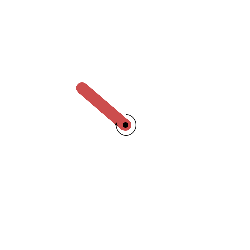

In [ ]:
learner.validate()

In [ ]:
#|hide
#|eval: false
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev import nbdev_export
    nbdev_export()